In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_rows', 1000)

In [2]:
!ls

Comext Open Data.ipynb
Country Distance
Instructions on how to use the bulkdownload facility.pdf
Readme.md
country_codes.csv
our_data


In [3]:
%%time
main_dir = 'our_data/'

path_hs = main_dir + 'transportation_hs'
all_hs = glob.glob(path_hs + "/*.dat")

list_df_hs = []

for filename in all_hs:
    df_tmp_hs = pd.read_csv(filename, index_col=None, header=0)
    list_df_hs.append(df_tmp_hs)

df_hs = pd.concat(list_df_hs, axis=0, ignore_index=True)

path_nstr = main_dir + 'transportation_nstr'
all_nstr = glob.glob(path_nstr + "/*.dat")

list_df_nstr = []

for filename in all_nstr:
    df_tmp_nstr = pd.read_csv(filename, index_col=None, header=0)
    list_df_nstr.append(df_tmp_nstr)

df_nstr = pd.concat(list_df_nstr, axis=0, ignore_index=True)

<decorator-gen-54>:2: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 51.1 s, sys: 10.5 s, total: 1min 1s
Wall time: 1min 4s


# DataFrames

## Description of the columns of df_hs DataFrame

* **DECLARANT and DECLARANT_ISO**: The Declarant (or reporting country) is the country compiling and sending data to Eurostat.
* **PARTNER and PARTNER_ISO**: The partner country is the last known country of destination for exports, the country of origin for imports from non-EU countries and the country of consignment for imports from Member States.
* **PRODUCT_HS**: file txt CN, SITC, CPA_2002, CPA_2008, CPA_2.1, BEC or by SECTION.
* **FLOW**: 1 import, 2 export.
* **TRANSPORT_MODE**: file txt in the main folder
* **PERIOD**: This code refers to the reference period.
* **VALUE_IN_EUROS**: euros already numpy.int64.
* **QUANTITY_IN_KG**: kg already numpy.int64.

In [4]:
# open the ransport mode txt file
transp_mode = pd.read_csv('our_data/TRANSPORT_MODE.txt', sep= '\t').rename({'0':'TRANSPORT_MODE', 'Unknown':'TYPE_TRANSP_MODE'}, axis=1)

# merge the dataframes
df_hs = df_hs.merge(transp_mode, on='TRANSPORT_MODE')

# create a dataframe for the flow
flow = pd.DataFrame({'FLOW':[0,1], 'TYPE_FLOW':['import', 'export']})

# merge the dataframes
df_hs = df_hs.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_hs['MONTH'] = df_hs['PERIOD'].apply(lambda x: str(x)[4:])
df_hs['YEAR'] = df_hs['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_hs.drop('PERIOD', axis=1, inplace=True)

In [5]:
df_hs[df_hs['PRODUCT_HS']=='TOTAL']; # can I delete this, right?

## Description of the columns of df_hs DataFrame

In [6]:
df_nstr = df_nstr.merge(transp_mode, on='TRANSPORT_MODE')

# merge the dataframes
df_nstr = df_nstr.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_nstr['MONTH'] = df_nstr['PERIOD'].apply(lambda x: str(x)[4:])
df_nstr['YEAR'] = df_nstr['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_nstr.drop('PERIOD', axis=1, inplace=True)

In [7]:
# container
cont = pd.read_csv('our_data/CONTAINER_MODE.txt', header=None, sep='\t').rename({0:'CONTAINER_MODE', 
                                                                                 1:'TYPE_CONTAINER_MODE'}, axis=1)

df_nstr = df_nstr.merge(cont, on='CONTAINER_MODE')

In [8]:
df_nstr.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_NSTR,FLOW,TRANSPORT_MODE,CONTAINER_MODE,TRANSPORT_MEANS_NAT,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,TYPE_CONTAINER_MODE
0,1,FR,21,XC,939,1,1,1,1,1348,68,Sea,export,01,2019,Containerised
1,1,FR,21,XC,TOT,1,1,1,1,1348,68,Sea,export,01,2019,Containerised
2,1,FR,28,NO,819,1,1,1,3,7301,22480,Sea,export,01,2019,Containerised
3,1,FR,28,NO,819,1,1,1,28,92016,72000,Sea,export,01,2019,Containerised
4,1,FR,28,NO,910,1,1,1,958,261480,392,Sea,export,01,2019,Containerised


# Merging of the two dataframes

In [9]:
df_hs['PRODUCT_TYPE'] = 'HS'
df_nstr['PRODUCT_TYPE'] = 'NSTR'

df_hs = df_hs.rename({'PRODUCT_HS': 'PRODUCT_CODE'}, axis=1)
df_nstr = df_nstr.rename({'PRODUCT_NSTR': 'PRODUCT_CODE'}, axis=1)

df_tot = df_hs.append(df_nstr, ignore_index=True).drop(['CONTAINER_MODE', 'TRANSPORT_MEANS_NAT', 'TYPE_CONTAINER_MODE'], axis=1)

df_tot;

In [10]:
# remove the TOT rows

# too much time
index_del = []
for i in range(len(df_tot)):
    if df_tot['PRODUCT_CODE'][i] == 'TOT' or df_tot['PRODUCT_CODE'][i] == 'TOTAL':
        index_del.append(i)

df_tot = df_tot.drop(index_del, axis=0).reset_index(drop=True)

In [11]:
df_tot = df_tot.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)

In [12]:
df_tot = df_tot.dropna(how='any')

## Distance

In [20]:
distance_df = pd.read_csv('Country Distance/distance.csv').sort_values(by='InputID').reset_index(drop=True)
distance_df['InputID'] = distance_df['InputID'].apply(lambda x: x.replace(' ', ''))
distance_df['TargetID'] = distance_df['TargetID'].apply(lambda x: x.replace(' ', ''))
distance_df.head()

,InputID,TargetID,Distance
0,ABW,ZWE,1.151116e+07
1,ABW,NIC,1.633202e+06
2,ABW,NER,8.373634e+06
3,ABW,NGA,8.486833e+06
4,ABW,NIU,1.148822e+07


In [21]:
ccode_df = pd.read_csv('country_codes.csv')
ccode_df.head();

In [22]:
map_dict = pd.Series(ccode_df.iloc[:,1].values,index= ccode_df.iloc[:,2]).to_dict()

In [23]:
distance_df.replace({"InputID":map_dict,"TargetID":map_dict},inplace=True)
distance_df.head()

,InputID,TargetID,Distance
0,AW,ZW,1.151116e+07
1,AW,NI,1.633202e+06
2,AW,NE,8.373634e+06
3,AW,NG,8.486833e+06
4,AW,NU,1.148822e+07


In [24]:
distance_df = distance_df.rename({'InputID':'DECLARANT_ISO', 'TargetID':'PARTNER_ISO'}, axis=1)

In [25]:
# df_tot = df_tot.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [26]:
# take the mean to the value of fuel
# scarse res.
# transoform the fuel in pollution
# Mi = Vmix *Qi*kH *Ci *10-6 /Ds
# type of fuel (sea, road, ...) some data 

In [27]:
# one layout for the graph
# spring layout
# export quantity and cut-off (treshold)
# local and global measure for greenness

- first step greenness and visualize and study of artcile about scc
- implementing a meaning for scc about world trande

# Graph

In [28]:
# graph construction
ser_nodes = df_tot['DECLARANT_ISO'].append(df_tot['PARTNER_ISO'])
nodes = ser_nodes.unique()

In [113]:
df_group = df_tot[['DECLARANT_ISO','PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG']].groupby(['DECLARANT_ISO', 'PARTNER_ISO']).sum().reset_index()
df_group = df_group.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [49]:
df_edges = df_group[['DECLARANT_ISO', 'PARTNER_ISO']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

In [50]:
# init graph
G = nx.DiGraph() # no time

In [51]:
G.add_nodes_from(nodes)
G.add_edges_from(tuple_edges) # add weight

In [68]:
# by time

def timeTresh_graph(df, month, year, t=1, q=None):
    '''
    The treshold (t) is between 0 and 1
    q is the quantity to apply tresh:
        'euro' for euro
        'kg' for quantity in kg
    '''
    
    G = nx.DiGraph()
    
    # nodes by time
    # df_tot_time = df[(df['YEAR'] == year) & (df['MONTH'] == month)]
    df_tot_time = df
    
    # perc
    df_tot_time['VALUE_IN_EUROS'] = df_tot_time['VALUE_IN_EUROS'].apply(lambda x: x/sum(df_tot_time['VALUE_IN_EUROS']))
    df_tot_time['QUANTITY_IN_KG'] = df_tot_time['QUANTITY_IN_KG'].apply(lambda x: x/sum(df_tot_time['QUANTITY_IN_KG']))

    if q == 'euro':
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS']]
        df_tot_time = df_tot_time[df_tot_time['VALUE_IN_EUROS']>=t]
    else:
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'QUANTITY_IN_KG']]
        df_tot_time = df_tot_time[df_tot_time['QUANTITY_IN_KG']<=t]
    
    ser_nodes = df_tot_time['DECLARANT_ISO'].append(df_tot_time['PARTNER_ISO'])
    nodes = ser_nodes.unique()
    
    # edges by time
    df_edges = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO']]
    tuple_edges = [tuple(r) for r in df_edges.to_numpy()]
    
    G.add_nodes_from(nodes)
    G.add_edges_from(tuple_edges) # add weight 

    return G

In [69]:
# plt.figure(figsize=(70,40))
# nx.draw(G);

In [92]:
# plt.figure(figsize=(70,40))
# nx.draw(timeTresh_graph(df_group, '02', '2020', t = 0.6, q = 'euro'));

In [114]:
# perc
df_group['VALUE_IN_EUROS'] = df_group['VALUE_IN_EUROS'].apply(lambda x: (x-df_group['VALUE_IN_EUROS'].min())/(df_group['VALUE_IN_EUROS'].max()-df_group['VALUE_IN_EUROS'].min()))
df_group['QUANTITY_IN_KG'] = df_group['QUANTITY_IN_KG'].apply(lambda x: (x-df_group['QUANTITY_IN_KG'].min())/(df_group['QUANTITY_IN_KG'].max()-df_group['QUANTITY_IN_KG'].min()))
df_group = df_group[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS']]
df_group = df_group[df_group['VALUE_IN_EUROS']>=0.3]

df_group.head()


,DECLARANT_ISO,PARTNER_ISO,VALUE_IN_EUROS
963,DE,CH,0.472232
969,DE,CN,0.907173
1079,DE,RU,0.382192
1080,DE,RU,0.382192
1118,DE,US,0.590385


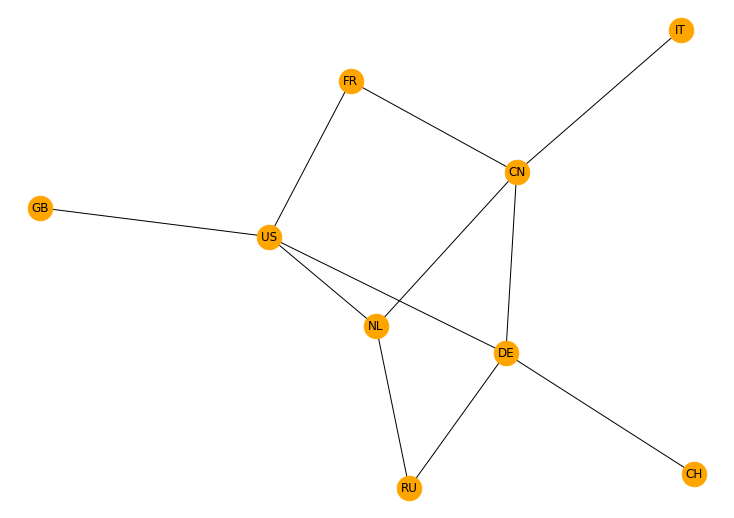

In [116]:
plt.figure(figsize=(10,7))
Gt = nx.Graph()
ser_nodes = df_group['DECLARANT_ISO'].append(df_group['PARTNER_ISO'])
nodes = ser_nodes.unique()

# edges by time
df_edges = df_group[['DECLARANT_ISO', 'PARTNER_ISO']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

Gt.add_nodes_from(nodes)
Gt.add_edges_from(tuple_edges) # add weight 
nx.draw(Gt, with_labels=True, node_size=600, node_color='orange')

# edges difference between import and export